In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import operator
from typing import Annotated, Optional, List
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel
from typing import Literal
import functools
from langchain_community.tools import TavilySearchResults
from langchain.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
import faiss
from langchain_core.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate
import pandas as pd

import pickle
from tqdm import tqdm

In [ ]:
df = pd.read_excel(r"data.xlsx")

In [ ]:
embeddings_model = OpenAIEmbeddings(model = 'text-embedding-3-small')
db = FAISS(
    embedding_function=embeddings_model,
    index=faiss.IndexFlatL2(1536),
    docstore=InMemoryDocstore(),
    index_to_docstore_id={}
)

for i in range(len(df)):
    db.add_texts([df['Message'][i]], metadatas=[{'User': df['User'][i]}], ids=[i])
db.save_local('test_data')

In [ ]:
data = 'test_data'

In [ ]:
gpt = ChatOpenAI(model_name="gpt-4o", temperature=0)
# claude = ChatAnthropic(model="claude-3-7-sonnet-20250219")

In [5]:
class FailureLog(TypedDict):
    detail: str
    failed_query: str
    failed_matched_mesasge: str
    failed_matched_candidate: str
    certainty: int
    # candidate_list: Optional[List[str]]

class AgentState(TypedDict):
    input_message: str
    username: Optional[str] = "Guest"
    count: Annotated[int, operator.add, lambda count, _: count + 1]
    evaluation_count: int = 1

    hypernym: Optional[str]
    matching_target: Optional[str]

    matched_message: Optional[str | dict]
    matched_username: Optional[str | dict]
    certainty: Optional[int]

    messages: str
    last_agent: str
    next_agent: str

    analyzed_message: Optional[str]
    search_info: Optional[str]
    reformed_query: Optional[str] = None
    candidates: Optional[List[str]]

    selectors_history: List[BaseMessage]
    failure_log: List[Optional[FailureLog]]
    history: Annotated[List[BaseMessage], operator.add]

In [6]:
def load_prompt(filepath: str) -> str:
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()

In [7]:
def get_initial_state(input_message, username):
    initial_state = AgentState(
        input_message=input_message,
        username=username,
        count=0,
        hypernym="",
        matching_target='',
        fail_or_not="",
        messages=input_message,
        history=[HumanMessage(content=input_message)],
        next_agent="Orchestrator",
        last_agent="User",
        analyzed_message=None,
        search_info=None,
        selectors_history=['.'],
        candidates=None,
        matched_message=None,
        matched_username=None,
        failure_log=[],
        evaluation_count=1
    )
    return initial_state

In [8]:
Orchestrator_prompt_text = load_prompt("prompts/Orchestrator.txt")

class OR_routeResponse(BaseModel):
    hypernym: Optional[str]
    matching_target: Optional[str]
    reasoning: str
    next_agent: Literal['Web_Search_Module', 'Message_Analyzer', 'Query_Reformer', 'Selector', 'Evaluator', '__end__']
    next_action: str

def orchestrator_def(state:dict):
    orchestrator_prompt = ChatPromptTemplate.from_messages([
        ("system", Orchestrator_prompt_text)],
    ).partial(recent_history=state["history"][-5:],
              analyzed_message=state["analyzed_message"],
              search_info=state["search_info"],)
    chain = (
        orchestrator_prompt
        | gpt.with_structured_output(OR_routeResponse))
    response = chain.invoke(state)
    updated_state = {
        "hypernym": response.hypernym if response.hypernym else "",
        "matching_target": response.matching_target if response.matching_target else "",
        "next_agent": response.next_agent,
        "messages": response.reasoning+"\n"+response.next_action,
        "history": [AIMessage(content=response.reasoning+'\n'+response.next_action, name="Orchestrator")],
        "last_agent": "Orchestrator"
    }
    state.update(updated_state)

    if state['analyzed_message'] == None and state['candidates'] == None and state['next_agent'] == '__end__':
        updated_state = {
            "next_agent": "Message_Analyzer"
        }
        state.update(updated_state)

    print(state["history"][-1])
    print(state["next_agent"])
    return state

In [9]:
MA_prompt_text = load_prompt("prompts/Message_Analyzer.txt")

class MA_routeResponse(BaseModel):
    hypernym: Optional[str]
    matching_target: Optional[str]
    reasoning: str
    next_agent: Literal['Orchestrator', 'Web_Search_Module']
    next_action: str

def message_analyzer_def(state:dict):
    if state['count'] > 7:
        updated_state = {
            "next_agent": "Orchestrator",
            "messages": "현재 병목이 발생하는 것으로 보이니, Query_Reformer로 넘어가겠습니다.",
            "history": [AIMessage(content="현재 병목이 발생하는 것으로 보이니, Query_Reformer로 넘어가겠습니다.", name="Message_Analyzer")],
            "last_agent": "Message_Analyzer"
        }
        state.update(updated_state)
        return state

    MA_prompt = ChatPromptTemplate.from_messages([
    ("system", MA_prompt_text)]).partial(recent_history=state["history"][-5:])
    chain = (
        MA_prompt
        | gpt.with_structured_output(MA_routeResponse))
    response = chain.invoke(state)
    updated_state = {
        "hypernym": response.hypernym if response.hypernym else "",
        "matching_target": response.matching_target if response.matching_target else "",
        "next_agent": response.next_agent,
        "messages": response.reasoning+"\n"+response.next_action,
        "history": [AIMessage(content=response.reasoning+'\n'+response.next_action, name="Message_Analyzer")],
        "last_agent": "Message_Analyzer",
        "analyzed_message": response.reasoning+"\n"+response.next_action
    }
    state.update(updated_state)
    print(state["history"][-1])
    print(state["next_agent"])
    return state

In [10]:
# import os
# os.environ["TAVILY_API_KEY"] = "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"

@tool
def web_search_tool(query: str):
    """주어진 쿼리에 대해 외부 검색을 실행하고, observation(검색결과)를 반환합니다."""
    web_search = TavilySearchResults(max_results=5)
    search_results = web_search.invoke(query)
    return [item.get("content") for item in search_results]

search_prompt_text = load_prompt("prompts/Web_Search_Module.txt")

def web_search_def(state:dict, agent):
    # if state['count'] > 7:
    #     updated_state = {
    #         "next_agent": "Orchestrator",
    #         "messages": "현재 병목이 발생하는 것으로 보이니, Query_Reformer로 넘어가겠습니다.",
    #         "history": [AIMessage(content="현재 병목이 발생하는 것으로 보이니, Query_Reformer로 넘어가겠습니다.", name="Message_Analyzer")],
    #         "last_agent": "Web_Search_Module"
    #     }
    #     state.update(updated_state)
    #     return state
    response = agent.invoke(state)
    updated_state ={
    "next_agent": state['last_agent'],
    "messages": response['messages'][-1].content,
    "history": [AIMessage(content=response["messages"][-1].content, name="Web_Search_Module")],
    "last_agent": "Web_Search_Module",
    "search_info": response['messages'][-1].content,
    }
    state.update(updated_state)
    print(state["history"][-1])
    print(state["next_agent"])
    return state

web_search_module = create_react_agent(gpt, tools=[web_search_tool], state_modifier=search_prompt_text)
web_search_node = functools.partial(web_search_def, agent=web_search_module)


In [11]:
embeddings_model = OpenAIEmbeddings(model = 'text-embedding-3-small')
db = FAISS(
    embedding_function=embeddings_model,
    index=faiss.IndexFlatL2(1536),
    docstore=InMemoryDocstore(),
    index_to_docstore_id={}
)
db = db.load_local(data, embeddings_model, allow_dangerous_deserialization=True)
docs = db.docstore._dict.values()
faiss_retriever = db.as_retriever(search_kwargs={"k": 5})

In [12]:
QR_prompt_text = load_prompt("prompts/Query_Reformer.txt")

class QR_routeResponse(BaseModel):
    result: str
    reasoning: str
    next_agent: Literal['Selector', 'Web_Search_Module']
    next_action: str

def get_candidates(query, username):
    if hasattr(query, 'content'):
        query = query.content
    result = faiss_retriever.invoke(query)
    list_ = [f"{x.metadata['User']}: {x.page_content}" for x in result if x.metadata['User']!=username]
    return list_

QR_prompt = ChatPromptTemplate.from_messages([
    ("system", QR_prompt_text)])

def query_reformer_def(state:dict):
    chain = (
        QR_prompt
        | gpt.with_structured_output(QR_routeResponse)
    )    
    response = chain.invoke(state)
    candidates_ = get_candidates(state['input_message'], state['username']) + get_candidates(response.result.split("/")[0], state['username']) + get_candidates(response.result.split("/")[1], state['username'])
    candidates = list(set(candidates_))
    updated_state ={
    "next_agent": response.next_agent,
    "messages": f'Reformed Queries - {response.result}, Reasoning - {response.reasoning}\n{response.next_action}',
    "reformed_query": response.result,
    "history": [AIMessage(content=(f'Reformed Queries - {response.result}, Reasoning - {response.reasoning}\n{response.next_action}'), name="Query_Reformer")],
    "last_agent": "Query_Reformer",
    "candidates": candidates
    }
    state.update(updated_state)
    print(state["history"][-1])
    print(state["next_agent"])
    return state

In [13]:
class Selector(TypedDict):
    candidate: str
    coherence_with_user: str
    score: float

class personaselectors_routeResponse(BaseModel):
    user_persona: str
    candidates: list[Selector]

PersonaMatch_prompt_text = load_prompt("prompts/Selector_PersonaMatch.txt")
PersonaMatch_prompt = ChatPromptTemplate.from_messages(
    [ ("system", PersonaMatch_prompt_text)])

def PersonaMatch_def(state:dict):
    chain = (
        PersonaMatch_prompt
        | gpt.with_structured_output(personaselectors_routeResponse)
    )
    response = chain.invoke(state)
    updated_state ={
    "selectors_history": state["selectors_history"]+[f"This is from PersonaMatch\n: {response.candidates}"]
    }
    state.update(updated_state)
    print(state["selectors_history"][-1])
    return state

In [14]:
df1 = pd.read_excel("다대다 매칭.xlsx")
df_list = [f"{x}: {y}" for x, y in zip(df1.iloc[:, 0], df1.iloc[:, 1])]

In [ ]:
# def get_state(int):
#     initial_state = AgentState(
#         input_message=df1.iloc[int, 1],
#         username=df1.iloc[int, 0],
#         count=0,
#         hypernym="",
#         matching_target='',
#         fail_or_not="",
#         messages=df1.iloc[int, 1],
#         history=[HumanMessage(content=df1.iloc[int, 1])],
#         next_agent="Orchestrator",
#         last_agent="User",
#         analyzed_message=None,
#         search_info=None,
#         selectors_history=['.'],
#         candidates=df_list,
#         matched_message=None,
#         matched_username=None,
#         failure_log=[],
#         evaluation_count=1
#     )
#     return initial_state

# initial_state = get_state(10)

In [17]:
class roleselectors_routeResponse(BaseModel):
    user_role: str
    candidates: list[Selector]

RoleMatch_prompt_text = load_prompt("prompts/Selector_RoleMatch.txt")
RoleMatch_prompt = ChatPromptTemplate.from_messages(
    [ ("system", RoleMatch_prompt_text)])
def RoleMatch_def(state:dict):
    chain = (
        RoleMatch_prompt
        | gpt.with_structured_output(roleselectors_routeResponse)
    )
    response = chain.invoke(state)
    updated_state ={
    "selectors_history": state["selectors_history"]+[f"This is from RoleMatch: {response.user_role}\n{response.candidates}"]
    }
    state.update(updated_state)
    print(state["selectors_history"][-1])
    return state

In [18]:
TypeMatch_prompt_text = load_prompt("prompts/Selector_TypeMatch.txt")
TypeMatch_prompt = ChatPromptTemplate.from_messages(
    [ ("system", TypeMatch_prompt_text)])
def TypeMatch_def(state:dict):
    chain = (
        TypeMatch_prompt
        | gpt.with_structured_output(subselectors_routeResponse)
    )
    response = chain.invoke(state)
    updated_state ={
    "selectors_history": state["selectors_history"]+[f"This is from TypeMatch\n{response.opinion}"]
    }
    state.update(updated_state)
    print(state["selectors_history"][-1])
    return state

In [19]:
selector_prompt_text = load_prompt("prompts/Selector.txt")

class selector_routeResponse(BaseModel):
    matched_message: str
    matched_username: str
    reasoning: str
    next_agent: Literal["Evaluator", "Orchestrator"]
    next_action: str
    certainty: int

selector_prompt = ChatPromptTemplate.from_messages([
    ("system", selector_prompt_text)])

def selector_def(state:dict):
    chain = (
        selector_prompt
        | gpt.with_structured_output(selector_routeResponse)
    )
    response = chain.invoke(state)
    updated_state ={
    "next_agent": response.next_agent,
    "messages": response.reasoning+" "+response.next_action,
    "history": [AIMessage(content=(response.reasoning+" "+response.next_action), name="Selector")],
    "last_agent": "Selector",
    "matched_message": response.matched_message,
    "matched_username": response.matched_username,
    "certainty": response.certainty
    }
    state.update(updated_state)
    print(state["history"][-1])
    print(state["next_agent"])
    return state

In [20]:
def selection(state:dict):
    updated_state ={
    "selectors_history": []
    }
    state.update(updated_state)
    state = TypeMatch_def(state)
    state = RoleMatch_def(state)
    state = PersonaMatch_def(state)
    state = selector_def(state)
    return state

In [21]:
evaluator_prompt_text = load_prompt("prompts/Evaluator.txt")

class e_routeResponse(BaseModel):
    matched_username: str
    matched_message: str
    fail_or_not: str
    reasoning: str
    next_agent: Literal["Orchestrator", '__end__']
    next_action: str
    success_or_fail: str
    detail: str
    failed_query: str
    matched_candidate: str
    certainty: int
    # failed_candidate_list: Optional[List[str]]

def evaluator_def(state:dict):
    if not state['certainty']:
        updated_state = {
            "next_agent": "Orchestrator",
            "messages": "Query Reform 및 Select 과정을 무조건 거쳐야 합니다.",
            "history": [AIMessage(content="Query Reform 및 Select 과정을 무조건 거쳐야 합니다.", name="Evaluator")],
            "last_agent": "Evaluator"
        }
        state.update(updated_state)
        return state

    if state["evaluation_count"] == 2:
        evaluator_prompt = ChatPromptTemplate.from_messages(
            [ ("system", evaluator_prompt_text)]
            ).partial(chat_history=state["history"][-10:], candidates="일단은 Selector가 선택한 후보만 평가해보세요.")
    else:
        evaluator_prompt = ChatPromptTemplate.from_messages(
            [ ("system", evaluator_prompt_text)]
            ).partial(chat_history=state["history"][-10:], candidates=state["candidates"])
    
    chain = (
        evaluator_prompt
        | gpt.with_structured_output(e_routeResponse)
    )
    response = chain.invoke(state)

    updated_state ={
    "fail_or_not": response.fail_or_not,
    "next_agent": response.next_agent,
    "messages": response.reasoning+"\n"+response.next_action,
    "history": [AIMessage(content=(response.reasoning+" "+response.next_action), name="Evaluator")],
    "evaluation_count": state["evaluation_count"] + 1,
    "last_agent": "Evaluator",
    "matched_username": response.matched_username,
    "matched_message": response.matched_message,
    }
    print(updated_state["evaluation_count"])

    if response.fail_or_not == "fail":
        fail_already_logged = any(
            log.get('failed_matched_candidate') == response.matched_candidate
            and log.get('failed_query') == response.failed_query
            for log in state.get("failure_log", [])
        )
        
        if not fail_already_logged:
            failure_state = {
                "failure_log": state["failure_log"] + [{
                    "detail": response.reasoning+'\n'+response.detail,
                    "failed_query": response.failed_query,
                    "failed_matched_mesasge": response.matched_message,
                    "failed_matched_candidate": response.matched_candidate,
                    "certainty": response.certainty
                }]
            }
            state.update(failure_state)
    
    if updated_state['evaluation_count'] == 3:
        updated_state["next_agent"] = "__end__"
    
    state.update(updated_state)

    print(state["history"][-1])
    print(state["next_agent"])
    return state

In [22]:
memory = MemorySaver()

In [23]:
graph = StateGraph(AgentState)

graph.add_node("Orchestrator", orchestrator_def)
graph.add_node("Web_Search_Module", web_search_node)
graph.add_node("Message_Analyzer", message_analyzer_def)
graph.add_node("Query_Reformer", query_reformer_def)
graph.add_node("Selector", selection)
graph.add_node("Evaluator", evaluator_def)

graph.add_edge(START, "Orchestrator")

graph.add_conditional_edges(
        "Orchestrator",
        lambda state: state["next_agent"],
        {
        "Web_Search_Module": "Web_Search_Module",
        "Message_Analyzer": "Message_Analyzer",
        "Query_Reformer": "Query_Reformer",
        "Selector": "Selector",
        "Evaluator": "Evaluator",
        "__end__" : END
        }
        )

graph.add_conditional_edges(
        "Web_Search_Module",
        lambda state: state["next_agent"],
        {
        "Orchestrator": "Orchestrator",
        "Message_Analyzer": "Message_Analyzer"
        }
        )

graph.add_conditional_edges(
        "Message_Analyzer",
        lambda state: state["next_agent"],
        {
        "Orchestrator": "Orchestrator",
        "Web_Search_Module": "Web_Search_Module"
        }
        )   


graph.add_conditional_edges(
        "Query_Reformer",
        lambda state: state["next_agent"],
        {
        "Selector": "Selector"
        }
        )
    
graph.add_conditional_edges(
        "Selector",
        lambda state: state["next_agent"],
        {
        "Orchestrator": "Orchestrator",
        "Evaluator": "Evaluator"
        }
        )

graph.add_conditional_edges(
        "Evaluator",
        lambda state: state["next_agent"],
        {
        '__end__' : END,
        "Orchestrator": "Orchestrator",
        }
        )

compiled_graph = graph.compile(checkpointer=memory)

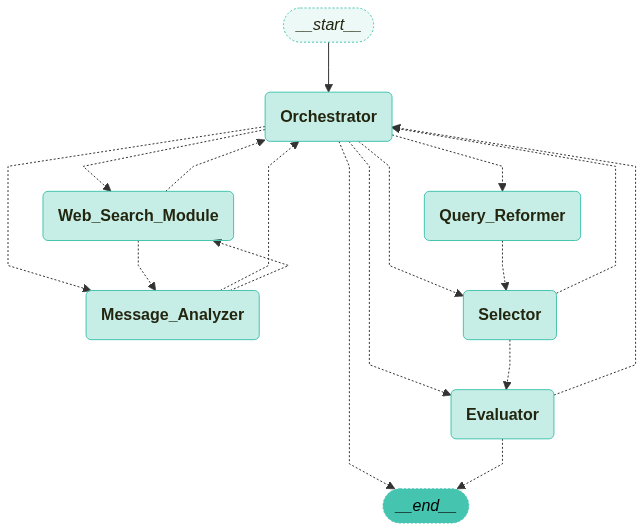

In [24]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(compiled_graph)

In [25]:
memory = MemorySaver()

config1 = RunnableConfig(
    recursion_limit=100,
    configurable={"thread_id": "1"},
)

config2 = RunnableConfig(
    recursion_limit=100,
    configurable={"thread_id": "2"},
)

config3 = RunnableConfig(
    recursion_limit=100,
    configurable={"thread_id": "3"},
)

config4 = RunnableConfig(
    recursion_limit=100,
    configurable={"thread_id": "4"},
)

In [ ]:
config1 = RunnableConfig(
    recursion_limit=100,
    configurable={"thread_id": "2"},
)
compiled_graph = graph.compile(checkpointer=memory)
input_message = df1.iloc[0, 1]
username = df1.iloc[0, 0]
initial_state = get_initial_state(input_message, username)

compiled_graph.invoke(initial_state, config=config1)